In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
import textwrap
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
def findMutInString(query):
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def getMutationList(Mutations_Position):
    target = 'caacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtctgc'
    target_list = list(target)
    mutation = ''
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(Mutations):
    if pd.isnull(Mutations) == False:
        try:
            coding_seq = 'aacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtct'
            codon_master_list = textwrap.wrap(coding_seq,3)
            codon_changes = ''
            position_list = []
            for mutation in Mutations.split(','):
                codon_pos = int((float(mutation[1:-1])-1)/3)
                if codon_pos not in position_list:
                    position_list.append(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                else:
                    old_index = position_list.index(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    mutation = Mutations.split(',')[old_index]
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                    l = codon_changes.split(",")
                    del l[old_index]
                    codon_changes = ",".join(l)
            return codon_changes[:-1]
        except ValueError:
            pass
        
def aachange(codon_changes):
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+518)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'
    return aa_change[:-1]  

def identifyNonSynonymousMutations(aa_change): 
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change)>0:
        if "," in aa_change:
            for mutation in aa_change.split(","):
                if mutation[0].upper() != mutation[-1].upper():
                    mutations_list.append(mutation)
        else :
            if aa_change[0].upper() != aa_change[-1].upper():    
                mutations_list.append(aa_change)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous

In [2]:
import scipy.stats as stats
df_A = pd.read_csv('ReplicateA_Cumulativesum_analsysis.csv', index_col=0)
df_B = pd.read_csv('ReplicateB_Cumulativesum_analsysis.csv', index_col=0)
df_C = pd.read_csv('ReplicateC_Cumulativesum_analsysis.csv', index_col=0)

df_A = df_A.set_index('Non_Syn_Mutations')
df_B = df_B.set_index('Non_Syn_Mutations')
df_C = df_C.set_index('Non_Syn_Mutations')

df_A = df_A[['No_Non_Syn','ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_A.columns = ['No_Non_Syn','ten_fitness_A','ten_error_A','fifty_fitness_A','fifty_error_A','hundred_fitness_A','hundred_error_A']
df_B = df_B[['ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_B.columns = ['ten_fitness_B','ten_error_B','fifty_fitness_B','fifty_error_B','hundred_fitness_B','hundred_error_B']
df_C = df_C[['ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_C.columns = ['ten_fitness_C','ten_error_C','fifty_fitness_C','fifty_error_C','hundred_fitness_C','hundred_error_C']

df_A = df_A.join(df_B[['ten_fitness_B','ten_error_B','fifty_fitness_B',\
                       'fifty_error_B','hundred_fitness_B','hundred_error_B']],how='outer')

df_A = df_A.join(df_C[['ten_fitness_C','ten_error_C','fifty_fitness_C','fifty_error_C',\
                       'hundred_fitness_C','hundred_error_C']],how='outer')
df_A = df_A.dropna()

In [3]:
"""
Maximum likelihood estimates model to valuate variant scores and standard errors from Rubin et al

"""
#Getting score for fitness at 10 ug/mL Rifampicin
for index in df_A.index:
    df = df_A.loc[index]
    b = df[['ten_fitness_A','ten_fitness_B','ten_fitness_C']].values
    err = df[['ten_error_A','ten_error_B','ten_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A.loc[index,'ten_fitness'] = b_array[49]
    df_A.loc[index,'ten_error'] = sig_array[49]
    df_A.loc[index,'ten_residual'] = sigma_diff[48]

#Getting score for fitness at 50 ug/mL Rifampicin
for index in df_A.index:
    df = df_A.loc[index]
    b = df[['fifty_fitness_A','fifty_fitness_B','fifty_fitness_C']].values
    err = df[['fifty_error_A','fifty_error_B','fifty_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A.loc[index,'fifty_fitness'] = b_array[49]
    df_A.loc[index,'fifty_error'] = sig_array[49]
    df_A.loc[index,'fifty_residual'] = sigma_diff[48]


#Getting score for fitness at 100 ug/mL Rifampicin
for index in df_A.index:
    df = df_A.loc[index]
    b = df[['hundred_fitness_A','hundred_fitness_B','hundred_fitness_C']].values
    err = df[['hundred_error_A','hundred_error_B','hundred_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A.loc[index,'hundred_fitness'] = b_array[49]
    df_A.loc[index,'hundred_error'] = sig_array[49]
    df_A.loc[index,'hundred_residual'] = sigma_diff[48]


In [4]:
import scipy.stats as stats
df_A_syn = pd.read_csv('ReplicateA_syn_Cumulativesum_analsysis.csv', index_col=0)
df_B_syn = pd.read_csv('ReplicateB_syn_Cumulativesum_analsysis.csv', index_col=0)
df_C_syn = pd.read_csv('ReplicateC_syn_Cumulativesum_analsysis.csv', index_col=0)

df_A_syn = df_A_syn.set_index('aa_change')
df_B_syn = df_B_syn.set_index('aa_change')
df_C_syn = df_C_syn.set_index('aa_change')

df_A_syn = df_A_syn[['No_Non_Syn','ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_A_syn.columns = ['No_Non_Syn','ten_fitness_A','ten_error_A','fifty_fitness_A','fifty_error_A','hundred_fitness_A','hundred_error_A']
df_B_syn = df_B_syn[['ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_B_syn.columns = ['ten_fitness_B','ten_error_B','fifty_fitness_B','fifty_error_B','hundred_fitness_B','hundred_error_B']
df_C_syn = df_C_syn[['ten_fitness','ten_error','fifty_fitness','fifty_error','hundred_fitness','hundred_error']]
df_C_syn.columns = ['ten_fitness_C','ten_error_C','fifty_fitness_C','fifty_error_C','hundred_fitness_C','hundred_error_C']

df_A_syn = df_A_syn.join(df_B_syn[['ten_fitness_B','ten_error_B','fifty_fitness_B',\
                       'fifty_error_B','hundred_fitness_B','hundred_error_B']],how='outer')

df_A_syn = df_A_syn.join(df_C_syn[['ten_fitness_C','ten_error_C','fifty_fitness_C','fifty_error_C',\
                       'hundred_fitness_C','hundred_error_C']],how='outer')
df_A_syn = df_A_syn.dropna()

In [5]:
"""
Maximum likelihood estimates model to valuate variant scores and standard errors from Rubin et al

"""
#Getting score for fitness at 10 ug/mL Rifampicin
for index in df_A_syn.index:
    df = df_A_syn.loc[index]
    b = df[['ten_fitness_A','ten_fitness_B','ten_fitness_C']].values
    err = df[['ten_error_A','ten_error_B','ten_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A_syn.loc[index,'ten_fitness'] = b_array[49]
    df_A_syn.loc[index,'ten_error'] = sig_array[49]
    df_A_syn.loc[index,'ten_residual'] = sigma_diff[48]

#Getting score for fitness at 50 ug/mL Rifampicin
for index in df_A_syn.index:
    df = df_A_syn.loc[index]
    b = df[['fifty_fitness_A','fifty_fitness_B','fifty_fitness_C']].values
    err = df[['fifty_error_A','fifty_error_B','fifty_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A_syn.loc[index,'fifty_fitness'] = b_array[49]
    df_A_syn.loc[index,'fifty_error'] = sig_array[49]
    df_A_syn.loc[index,'fifty_residual'] = sigma_diff[48]


#Getting score for fitness at 100 ug/mL Rifampicin
for index in df_A_syn.index:
    df = df_A_syn.loc[index]
    b = df[['hundred_fitness_A','hundred_fitness_B','hundred_fitness_C']].values
    err = df[['hundred_error_A','hundred_error_B','hundred_error_C']].values
    b_mean = b.mean()
    sigma = np.sqrt((np.square(b-b_mean).sum())/2)
    sig_array = np.array([])
    b_array = np.array([])
    sigma_diff = np.array([])
    for i in range(0,50):
        sig_array = np.append(sig_array,sigma)
        sig_sum = (np.square(err) + np.square(sig_array[i]))
        b_array = np.append(b_array,(np.power(sig_sum,-1)*b).sum()/(np.power(sig_sum,-1)).sum())
        sigma = np.sqrt((np.square(sig_array[i])*((np.power(sig_sum,-2)*np.square(b-b_array[i])).sum()\
            /(np.power(sig_sum,-1).sum()-np.power(sig_sum,-2).sum()/np.power(sig_sum,-1).sum()))))
        sigma_diff = np.append(sigma_diff,np.square(sigma) - np.square(sig_array[i]))
    df_A_syn.loc[index,'hundred_fitness'] = b_array[49]
    df_A_syn.loc[index,'hundred_error'] = sig_array[49]
    df_A_syn.loc[index,'hundred_residual'] = sigma_diff[48]


In [6]:
df_A = df_A.assign(Mutations = df_A.index.values)
df_A_syn = df_A_syn.assign(Mutations = df_A_syn.index.values)

In [8]:
df_A = df_A[['Mutations','No_Non_Syn','ten_fitness','ten_error','ten_residual',\
             'fifty_fitness','fifty_error','fifty_residual',\
             'hundred_fitness','hundred_error','hundred_residual']]
df_A_syn = df_A_syn[['Mutations','No_Non_Syn','ten_fitness','ten_error','ten_residual',\
             'fifty_fitness','fifty_error','fifty_residual',\
             'hundred_fitness','hundred_error','hundred_residual']]

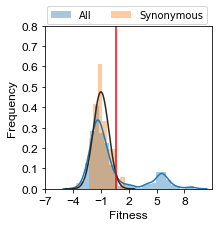

In [9]:
#The following graph generates a distribution of fitness effects for the scored mutations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

mu_10, sigma_10 = stats.norm.fit(df_A_syn.ten_fitness)
plt.figure(figsize=(3,3))
sns.distplot(df_A.hundred_fitness, label='All');
sns.distplot(df_A_syn.hundred_fitness, kde=False, fit=stats.norm, label='Synonymous')
plt.axvline(x = mu_10+2.96*sigma_10, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-7,11])
plt.ylim([0,0.8])

plt.xticks(np.arange(-7,11,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_10.svg', format = 'svg', dpi = 300)

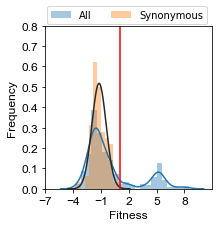

In [10]:
#The following graph generates a distribution of fitness effects for the scored mutations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

mu_50, sigma_50 = stats.norm.fit(df_A_syn.fifty_fitness)
plt.figure(figsize=(3,3))
sns.distplot(df_A.fifty_fitness, label='All');
sns.distplot(df_A_syn.fifty_fitness, kde=False, fit=stats.norm, label='Synonymous')
plt.axvline(x = mu_50+2.96*sigma_50, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-7,11])
plt.ylim([0,0.8])

plt.xticks(np.arange(-7,11,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_50.svg', format = 'svg', dpi = 300)

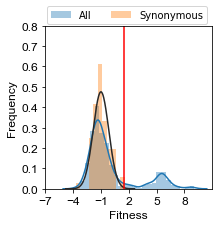

In [11]:
#The following graph generates a distribution of fitness effects for the scored mutations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

mu_100, sigma_100 = stats.norm.fit(df_A_syn.hundred_fitness)
plt.figure(figsize=(3,3))
sns.distplot(df_A.hundred_fitness, label='All');
sns.distplot(df_A_syn.hundred_fitness, kde=False, fit=stats.norm, label='Synonymous')
plt.axvline(x = mu_100+2.96*sigma_100, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-7,11])
plt.ylim([0,0.8])

plt.xticks(np.arange(-7,11,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_100.svg', format = 'svg', dpi = 300)

In [12]:
df_A.to_csv('Cumulative_score.csv')

In [13]:
#identify single mutants from the population and take mean
df_unique_single = df_A.loc[df_A.No_Non_Syn == 1]
df_unique_single = df_unique_single.loc[df_unique_single.Mutations.str.find('SYN') < 0]
df_unique_single = df_unique_single.loc[df_unique_single.Mutations.str.find('WT') < 0]
df_unique_single = df_unique_single.assign(Position = pd.to_numeric(df_unique_single.Mutations.str[1:-1]))

In [14]:
mu_10, sigma_10 = stats.norm.fit(df_A_syn.ten_fitness)
mu_50, sigma_50 = stats.norm.fit(df_A_syn.fifty_fitness)
mu_100, sigma_100 = stats.norm.fit(df_A_syn.hundred_fitness)

print mu_100, sigma_100 
print mu_50, sigma_50
print mu_10, sigma_10

-0.9785074316111203 0.8386471579001216
-1.1837722262448647 0.7710366913714406
-1.1669972619774613 0.6095654366616323


0.7304923310685641 8.445278318720743e-39


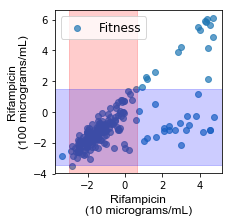

In [15]:
plt.figure(figsize=(3,3))
plt.scatter(df_unique_single.ten_fitness, df_unique_single.hundred_fitness, label = 'Fitness',alpha = 0.7)
plt.xlabel('Ten')
plt.ylabel('hundred')
plt.axvspan(mu_10+2.96*sigma_10,mu_10-2.96*sigma_10, alpha = 0.2, color = 'red')
plt.axhspan(mu_100+2.96*sigma_100,mu_100-2.96*sigma_100, alpha = 0.2, color = 'blue')
corr_10_AB, p_10_AB = stats.pearsonr(df_unique_single.ten_fitness, df_unique_single.hundred_fitness)
print corr_10_AB, p_10_AB
plt.legend(fontsize = 12)
plt.xlabel('Rifampicin\n(10 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.ylabel('Rifampicin\n(100 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.savefig('Correlation_10_100.svg', format = 'svg', dpi = 300)

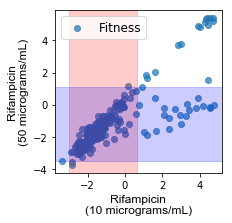

In [16]:
plt.figure(figsize=(3,3))
plt.scatter(df_unique_single.ten_fitness, df_unique_single.fifty_fitness, label = 'Fitness',alpha = 0.7)
plt.xlabel('Ten')
plt.ylabel('hundred')
plt.axvspan(mu_10+2.96*sigma_10,mu_10-2.96*sigma_10, alpha = 0.2, color = 'red')
plt.axhspan(mu_50+2.96*sigma_50,mu_50-2.96*sigma_50, alpha = 0.2, color = 'blue')
corr_10_AB, p_10_AB = stats.pearsonr(df_unique_single.ten_fitness, df_unique_single.hundred_fitness)
plt.legend(fontsize = 12)
plt.xlabel('Rifampicin\n(10 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.ylabel('Rifampicin\n(50 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.savefig('Correlation_10_50.svg', format = 'svg', dpi = 300)

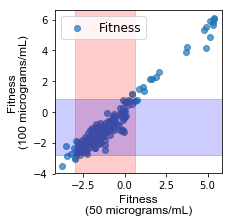

In [17]:
plt.figure(figsize=(3,3))
plt.scatter(df_unique_single.fifty_fitness, df_unique_single.hundred_fitness, label = 'Fitness',alpha = 0.7)
plt.xlabel('Ten')
plt.ylabel('hundred')
plt.axvspan(mu_50+2.96*sigma_10,mu_50-2.96*sigma_10, alpha = 0.2, color = 'red')
plt.axhspan(mu_100+2.96*sigma_10,mu_100-2.96*sigma_10, alpha = 0.2, color = 'blue')

plt.legend(fontsize = 12)
plt.xlabel('Fitness\n(50 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.ylabel('Fitness\n(100 micrograms/mL)', fontname = 'Arial', fontsize = 12)
plt.savefig('Correlation_100_50.svg', format = 'svg', dpi = 300)

17


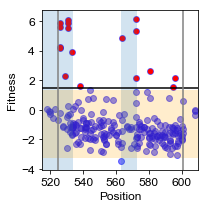

In [18]:
df_top_100 = df_unique_single.loc[df_unique_single.hundred_fitness >= mu_100+2.96*sigma_100]
df_top_100 = df_top_100.set_index('Mutations')
print len(df_top_100)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(515, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_100-2.96*sigma_50, mu_100+2.96*sigma_50, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.hundred_fitness, color = 'blue', alpha = 0.5)
df_top_100.plot('Position','hundred_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_100+2.96*sigma_100, color = 'black')
plt.axvline(x = 525, color = 'grey')
plt.axvline(x = 601, color = 'grey')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.xlim(515,610)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_100.svg', format = 'svg', dpi = 300)

17


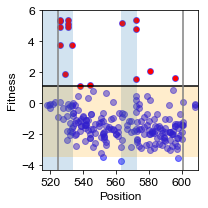

In [19]:
df_top_50 = df_unique_single.loc[df_unique_single.fifty_fitness >= mu_50+2.96*sigma_50]
df_top_50 = df_top_50.set_index('Mutations')
print len(df_top_50)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(515, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_50-2.96*sigma_50, mu_50+2.96*sigma_50, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.fifty_fitness, color = 'blue', alpha = 0.5)
df_top_50.plot('Position','fifty_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_50+2.96*sigma_50, color = 'black')
plt.axvline(x = 525, color = 'grey')
plt.axvline(x = 601, color = 'grey')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.xlim(515,610)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_50.svg', format = 'svg', dpi = 300)

37


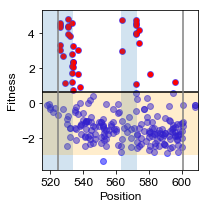

In [20]:
df_top_10 = df_unique_single.loc[df_unique_single.ten_fitness >= mu_10+2.96*sigma_10]
df_top_10 = df_top_10.set_index('Mutations')
print len(df_top_10)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(515, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_10-2.96*sigma_10, mu_10+2.96*sigma_10, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.ten_fitness, color = 'blue', alpha = 0.5)
df_top_10.plot('Position','ten_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_10+2.96*sigma_10, color = 'black')
plt.axvline(x = 525, color = 'grey')
plt.axvline(x = 601, color = 'grey')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.xlim(515,610)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_10.svg', format = 'svg', dpi = 300)

In [22]:
mask = (df_unique_single.Position == 526)|\
       (df_unique_single.Position == 529)|\
        (df_unique_single.Position == 572)|\
        (df_unique_single.Position == 531)|\
        (df_unique_single.Position == 533)
df_unique_single.loc[mask, 'Interacting'] = 'Yes'
values = {'Interacting': 'No'}
df_unique_single= df_unique_single.fillna(value=values)

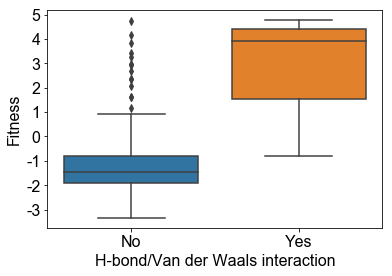

In [24]:
import seaborn as sns
ax = sns.boxplot(x="Interacting", y="ten_fitness", data=df_unique_single)
ax.set_xlabel('H-bond/Van der Waals interaction', fontname = 'Arial', fontsize = 16)
ax.set_ylabel('Fitness', fontname = 'Arial', fontsize = 16)
ax.set_yticklabels(np.arange(-4,7,1), fontname = 'Arial', fontsize = 16);
ax.set_xticklabels(['No','Yes'], fontname = 'Arial', fontsize = 16);
plt.savefig('INteracting_v_noninteracting_10.svg', format = 'svg', dpi = 300)


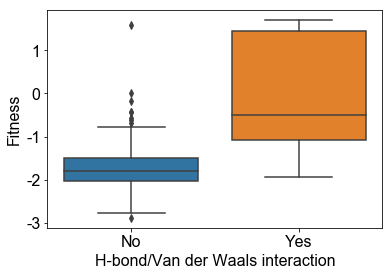

In [25]:
import seaborn as sns
ax = sns.boxplot(x="Interacting", y="fifty_fitness", data=df_unique_single)
ax.set_xlabel('H-bond/Van der Waals interaction', fontname = 'Arial', fontsize = 16)
ax.set_ylabel('Fitness', fontname = 'Arial', fontsize = 16)
ax.set_yticklabels(np.arange(-4,7,1), fontname = 'Arial', fontsize = 16);
ax.set_xticklabels(['No','Yes'], fontname = 'Arial', fontsize = 16);
plt.savefig('INteracting_v_noninteracting_50.svg', format = 'svg', dpi = 300)


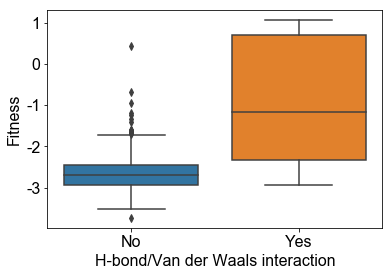

In [26]:
import seaborn as sns
ax = sns.boxplot(x="Interacting", y="hundred_fitness", data=df_unique_single)
ax.set_xlabel('H-bond/Van der Waals interaction', fontname = 'Arial', fontsize = 16)
ax.set_ylabel('Fitness', fontname = 'Arial', fontsize = 16)
ax.set_yticklabels(np.arange(-4,7,1), fontname = 'Arial', fontsize = 16);
ax.set_xticklabels(['No','Yes'], fontname = 'Arial', fontsize = 16);
plt.savefig('INteracting_v_noninteracting_100.svg', format = 'svg', dpi = 300)

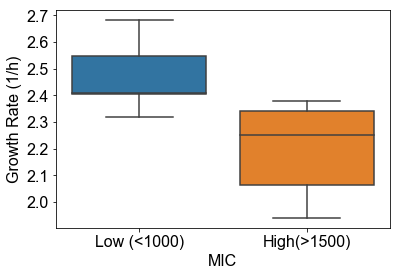

In [27]:
d = {'Mutation': ['L533R','I572S','G534C','I572M','L533Q','G534S','L533F',\
                  'P564L','H526L','I572F','S531F','I572H','R529H','S531Y'],\
    'Growth_rate':[2.682,2.612,2.404,2.320,2.41,2.48,2.41,\
                  2.38,2.37,2.31,2.25,2.17,1.96,1.94],\
    'MIC': ['Low','Low','Low','Low','Low','Low','Low',\
                  'High','High','High','High','High','High','High']}
df_MIC = pd.DataFrame(data=d)
ax = sns.boxplot(x="MIC", y="Growth_rate", data=df_MIC)
ax.set_xlabel('MIC', fontname = 'Arial', fontsize = 16)
ax.set_ylabel('Growth Rate (1/h)', fontname = 'Arial', fontsize = 16)
ax.set_yticklabels([1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8], fontname = 'Arial', fontsize = 16);
ax.set_xticklabels(['Low (<1000)','High(>1500)'], fontname = 'Arial', fontsize = 16);
plt.savefig('Low_versus_High_MIC.svg', format = 'svg', dpi = 300)

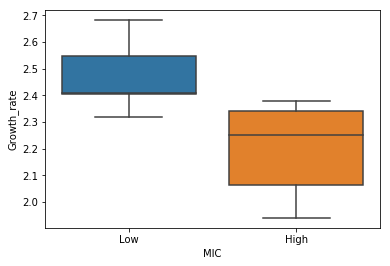

In [53]:
ax = sns.boxplot(x="MIC", y="Growth_rate", data=df_MIC)

In [42]:
df_MIC.loc[df_MIC.MIC == 'Low'].Growth_rate.mean()

2.474

In [36]:
from scipy import stats
stats.ttest_ind(df_MIC.loc[df_MIC.MIC == 'Low'].Growth_rate,\
                df_MIC.loc[df_MIC.MIC == 'High'].Growth_rate)

Ttest_indResult(statistic=3.2698566155427713, pvalue=0.006704999200034553)

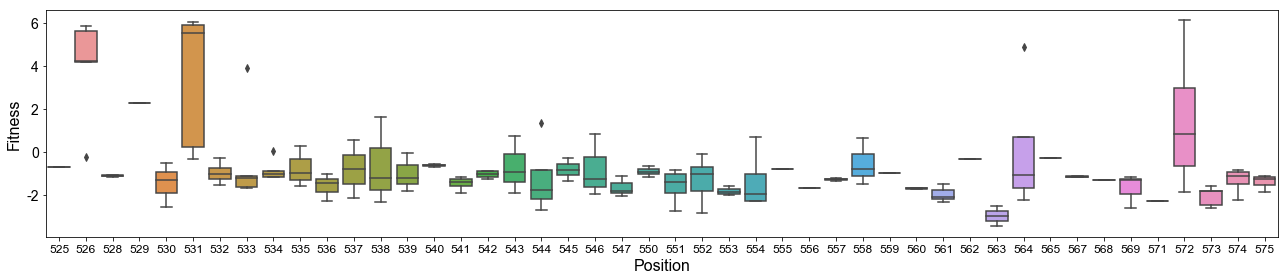

In [186]:
fig, ax = plt.subplots(figsize=[18,4])
data=df_unique_single.loc[(df_unique_single.Position >= 525)&\
                                                                             (df_unique_single.Position <= 575)]
ax = sns.boxplot(x="Position", y="hundred_fitness", data=df_unique_single.loc[(df_unique_single.Position >= 525)&\
                                                                             (df_unique_single.Position <= 575)])
ax.set_xlabel('Position', fontname = 'Arial', fontsize = 16)
ax.set_ylabel('Fitness', fontname = 'Arial', fontsize = 16)
ax.set_xticklabels(data.Position.drop_duplicates().sort_values().values,fontname = 'Arial', fontsize = 12);
ax.set_yticklabels(np.arange(-4,8,2), fontname = 'Arial', fontsize = 14);
plt.tight_layout()
plt.savefig('Fitness_by_position.svg', format = 'svg', dpi = 300)

In [181]:
data.Position.drop_duplicates().sort_values().values

array([525, 526, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 550, 551, 552, 553,
       554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 567,
       568, 569, 571, 572, 573, 574, 575], dtype=int64)

In [147]:
from scipy import stats
stats.ttest_ind(df_unique_single.loc[df_unique_single.Interacting == 'Yes'].ten_fitness,\
                df_unique_single.loc[df_unique_single.Interacting == 'No'].ten_fitness)

Ttest_indResult(statistic=13.780306556040058, pvalue=1.1571293085792355e-31)

In [153]:
from scipy import stats
stats.ttest_ind(df_unique_single.loc[df_unique_single.Interacting == 'Yes'].fifty_fitness,\
                df_unique_single.loc[df_unique_single.Interacting == 'No'].fifty_fitness)

Ttest_indResult(statistic=11.643217227191226, pvalue=8.652272744575491e-25)

In [154]:
from scipy import stats
stats.ttest_ind(df_unique_single.loc[df_unique_single.Interacting == 'Yes'].hundred_fitness,\
                df_unique_single.loc[df_unique_single.Interacting == 'No'].hundred_fitness)

Ttest_indResult(statistic=10.988612905371866, pvalue=9.907607889210916e-23)

In [111]:
df_position.sort_values('hundred_fitness', ascending=0)

,hundred_fitness,Position_name
Position,,
572,6.110926,572
531,6.044533,531
526,5.832197,526
564,4.879229,564
533,3.899669,533
581,2.611721,581
529,2.286099,529
596,2.123234,596
538,1.602670,538


In [129]:
df_unique_single_ten = df_unique_single[['Position','ten_fitness']]
df_position = df_unique_single_ten.groupby('Position').max()
df_position = df_position.loc[df_position.index.values >= 525]
df_position = df_position.loc[df_position.index.values < 601]
df_position.loc[527] = 0
df_position.loc[548] = 0
df_position.loc[549] = 0
df_position.loc[566] = 0
df_position.loc[570] = 0
df_position.loc[576] = 0
df_position.loc[566] = 0

df_position = df_position.assign(Position_name = df_position.index.values)
df_position = df_position.sort_values('Position_name')
df_position.to_clipboard()

In [130]:
aa_string = 'THKRRISALGPGGLTRERAGFEVRDVHPTHYGRVCPIETPEGPNIGLINSLSVYAQTNEYGFLETPYRKVTDGVVTD'
for index in df_position.index:
    df_position.loc[int(index),'aa'] = aa_string[int(index)-525]
    
df_position.loc[df_position['aa'] =='A', 'No_Atoms'] = 6
df_position.loc[df_position['aa'] =='C', 'No_Atoms'] = 7
df_position.loc[df_position['aa'] =='D', 'No_Atoms'] = 9
df_position.loc[df_position['aa'] =='E', 'No_Atoms'] = 10
df_position.loc[df_position['aa'] =='F', 'No_Atoms'] = 12
df_position.loc[df_position['aa'] =='G', 'No_Atoms'] = 5
df_position.loc[df_position['aa'] =='H', 'No_Atoms'] = 11
df_position.loc[df_position['aa'] =='I', 'No_Atoms'] = 9
df_position.loc[df_position['aa'] =='K', 'No_Atoms'] = 10
df_position.loc[df_position['aa'] =='L', 'No_Atoms'] = 9
df_position.loc[df_position['aa'] =='M', 'No_Atoms'] = 9
df_position.loc[df_position['aa'] =='N', 'No_Atoms'] = 9
df_position.loc[df_position['aa'] =='P', 'No_Atoms'] = 8
df_position.loc[df_position['aa'] =='Q', 'No_Atoms'] = 10
df_position.loc[df_position['aa'] =='R', 'No_Atoms'] = 12
df_position.loc[df_position['aa'] =='S', 'No_Atoms'] = 7
df_position.loc[df_position['aa'] =='T', 'No_Atoms'] = 8
df_position.loc[df_position['aa'] =='V', 'No_Atoms'] = 8
df_position.loc[df_position['aa'] =='W', 'No_Atoms'] = 15
df_position.loc[df_position['aa'] =='Y', 'No_Atoms'] = 13

df_position['No_Atoms'] = df_position['No_Atoms']-1.0
df_position
b_string = ''
for index in df_position.index:
    for i in range(0,int(df_position.loc[index,'No_Atoms'])):
        b_string = b_string+str(df_position.loc[index,'ten_fitness'])+","
b_string.replace('nan','0')

'-0.6778432056367072,-0.6778432056367072,-0.6778432056367072,-0.6778432056367072,-0.6778432056367072,-0.6778432056367072,-0.6778432056367072,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,4.540477764786951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,2.6876482057126916,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,1.1476399048467776,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,-0.9246259761935497,4.766483580879973,4.766483580879973,4.766483580879973,4.766483580

In [121]:
df_position

,hundred_fitness,Position_name,aa,No_Atoms
Position,,,,
525,-0.696922,525,T,7.0
526,5.832197,526,H,10.0
527,0.000000,527,K,9.0
528,-1.071099,528,R,11.0
529,2.286099,529,R,11.0
530,-0.520411,530,I,8.0
531,6.044533,531,S,6.0
532,-0.287304,532,A,5.0
533,3.899669,533,L,8.0


In [42]:
df_top_10.sort_values('Position')

,No_Non_Syn,ten_fitness,ten_error,ten_residual,fifty_fitness,fifty_error,fifty_residual,hundred_fitness,hundred_error,hundred_residual,Position
Mutations,,,,,,,,,,,
H526Y,1.0,4.315109,0.331667,-4.163336e-17,5.342652,1.807624e-01,0.000000e+00,5.832197,1.105832e-01,1.734723e-18,526
H526Q,1.0,3.298127,0.901674,2.220446e-16,0.077077,2.652244e-01,0.000000e+00,-0.236921,3.438090e-01,0.000000e+00,526
H526P,1.0,3.026404,0.842969,2.220446e-16,3.782689,1.124570e+00,4.440892e-16,4.225643,6.174696e-01,1.110223e-16,526
H526L,1.0,4.540478,2.362956,0.000000e+00,5.353881,2.467608e+00,-1.776357e-15,5.615053,2.255536e+00,0.000000e+00,526
H526N,1.0,4.426486,1.951664,0.000000e+00,4.923736,1.125926e+00,0.000000e+00,4.183585,1.487436e+00,8.881784e-16,526
R528L,1.0,2.687648,0.491984,2.775558e-17,-0.288571,3.493644e-01,-1.249001e-16,-1.164375,3.723582e-41,-5.467725e-80,528
R529H,1.0,1.147640,0.487670,0.000000e+00,1.862453,3.776317e-01,0.000000e+00,2.286099,3.562205e-01,0.000000e+00,529
S531Y,1.0,4.309717,2.018032,-1.776357e-15,5.150877,1.936051e+00,0.000000e+00,5.895026,1.523935e+00,0.000000e+00,531
S531C,1.0,4.766484,0.717247,2.220446e-16,-0.032533,7.902643e-01,0.000000e+00,-0.356510,2.026576e-01,-5.780149e-07,531


In [43]:
"""
The following code evaluated double mutants
"""
df_unique_double = df_A.loc[df_A.No_Non_Syn == 2]
df_unique_double = df_unique_double.assign(Mutations = df_unique_double.index.values)
df_unique_double = df_unique_double.assign(Mutation1 = df_unique_double.Mutations.str.split(",",expand=True)[0])
df_unique_double = df_unique_double.assign(Mutation2 = df_unique_double.Mutations.str.split(",",expand=True)[1])
df_unique_double = df_unique_double.assign(Position1 = df_unique_double.Mutation1.str[1:-1])
df_unique_double = df_unique_double.assign(Position2 = df_unique_double.Mutation2.str[1:-1])

In [44]:
df_top_10.Position.sort_values().drop_duplicates()

Mutations
H526Y    526
R528L    528
R529H    529
S531Y    531
A532P    532
L533F    533
G534V    534
G537A    537
L538P    538
P564R    564
I572T    572
S574Y    574
T581A    581
D596N    596
Name: Position, dtype: int64

In [45]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
df_unique_double_ten = df_unique_double[['Mutations',\
                                         'ten_fitness','ten_error','Mutation1','Mutation2']]

df_unique_single_ten = df_unique_single[['Mutations','Mutations',\
                                         'ten_fitness','ten_error']]
df_unique_single_ten.columns = ['Mutation1','Mutation1A',\
                                         'ten_fitness1','ten_error1']
df_unique_double_ten = df_unique_double_ten.join(df_unique_single_ten.set_index('Mutation1'), on='Mutation1')
df_unique_single_ten.columns = ['Mutation2','Mutation2A',\
                                         'ten_fitness2','ten_error2']
df_unique_double_ten = df_unique_double_ten.join(df_unique_single_ten.set_index('Mutation2'), on='Mutation2')

df_unique_double_ten['fitness_sum'] = df_unique_double_ten['ten_fitness1'] + df_unique_double_ten['ten_fitness2']
df_unique_double_ten['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_ten['ten_error1'])\
                                         + np.square(df_unique_double_ten['ten_error2']))

df_unique_double_ten = df_unique_double_ten.dropna()

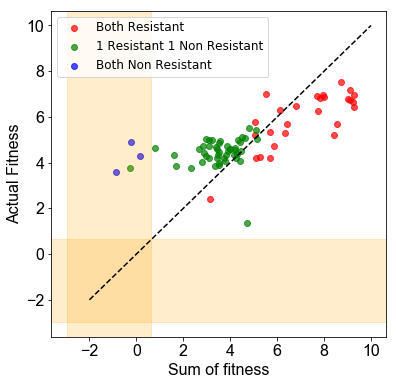

In [46]:
plt.figure(figsize=(6,6))

df_positives_10 = df_unique_double_ten.loc[(df_unique_double_ten.ten_fitness1 > mu_10+2.96*sigma_10)\
                                           & (df_unique_double_ten.ten_fitness2 > mu_10+2.96*sigma_10)]

plt.scatter(df_positives_10.fitness_sum, df_positives_10.ten_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_10 = df_unique_double_ten.loc[((df_unique_double_ten.ten_fitness1 > mu_10+2.96*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 < mu_10+2.96*sigma_10))|
                                        ((df_unique_double_ten.ten_fitness1 < mu_10+2.96*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 > mu_10+2.96*sigma_10))]
plt.scatter(df_neutral_10.fitness_sum, df_neutral_10.ten_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Non Resistant')

df_neutral_double_10 = df_unique_double_ten.loc[((df_unique_double_ten.ten_fitness1 < mu_10+2.96*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 < mu_10+2.96*sigma_10))]

plt.scatter(df_neutral_double_10.fitness_sum, df_neutral_double_10.ten_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Non Resistant')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_10+2.96*sigma_10, mu_10-2.96*sigma_10, alpha = 0.2, color = 'orange')
plt.axvspan(mu_10+2.96*sigma_10, mu_10-2.96*sigma_10, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 16)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 16)
plt.xticks(fontname = 'Arial', fontsize = 16)
plt.yticks(fontname = 'Arial', fontsize = 16)

plt.legend(fontsize = 12)
plt.savefig('Actual versus Predicted 10.svg',format = 'svg', dpi = 300)

In [47]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
df_unique_double_fifty = df_unique_double[['Mutations',\
                                         'fifty_fitness','fifty_error','Mutation1','Mutation2']]

df_unique_single_fifty = df_unique_single[['Mutations','Mutations',\
                                         'fifty_fitness','fifty_error']]
df_unique_single_fifty.columns = ['Mutation1','Mutation1A',\
                                         'fifty_fitness1','fifty_error1']
df_unique_double_fifty = df_unique_double_fifty.join(df_unique_single_fifty.set_index('Mutation1'), on='Mutation1')
df_unique_single_fifty.columns = ['Mutation2','Mutation2A',\
                                         'fifty_fitness2','fifty_error2']
df_unique_double_fifty = df_unique_double_fifty.join(df_unique_single_fifty.set_index('Mutation2'), on='Mutation2')

df_unique_double_fifty['fitness_sum'] = df_unique_double_fifty['fifty_fitness1'] + df_unique_double_fifty['fifty_fitness2']
df_unique_double_fifty['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_fifty['fifty_error1'])\
                                         + np.square(df_unique_double_fifty['fifty_error2']))

df_unique_double_fifty = df_unique_double_fifty.dropna()

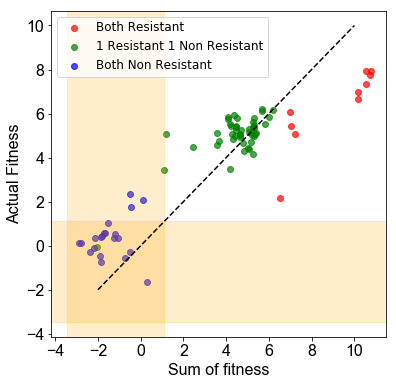

In [48]:
plt.figure(figsize=(6,6))

df_positives_50 = df_unique_double_fifty.loc[(df_unique_double_fifty.fifty_fitness1 > mu_50+2.96*sigma_50)\
                                           & (df_unique_double_fifty.fifty_fitness2 > mu_50+2.96*sigma_50)]

plt.scatter(df_positives_50.fitness_sum, df_positives_50.fifty_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_50 = df_unique_double_fifty.loc[((df_unique_double_fifty.fifty_fitness1 > mu_50+2.96*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 < mu_50+2.96*sigma_50))|
                                        ((df_unique_double_fifty.fifty_fitness1 < mu_50+2.96*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 > mu_50+2.96*sigma_50))]
plt.scatter(df_neutral_50.fitness_sum, df_neutral_50.fifty_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Non Resistant')

df_neutral_double_50 = df_unique_double_fifty.loc[((df_unique_double_fifty.fifty_fitness1 < mu_50+2.96*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 < mu_50+2.96*sigma_50))]

plt.scatter(df_neutral_double_50.fitness_sum, df_neutral_double_50.fifty_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Non Resistant')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_50+2.96*sigma_50, mu_50-2.96*sigma_50, alpha = 0.2, color = 'orange')
plt.axvspan(mu_50+2.96*sigma_50, mu_50-2.96*sigma_50, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 16)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 16)
plt.xticks(fontname = 'Arial', fontsize = 16)
plt.yticks(fontname = 'Arial', fontsize = 16)

plt.legend(fontsize = 12)
plt.savefig('Actual versus Predicted 50.svg',format = 'svg', dpi = 300)

In [49]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
df_unique_double_hundred = df_unique_double[['Mutations',\
                                         'hundred_fitness','hundred_error','Mutation1','Mutation2']]

df_unique_single_hundred = df_unique_single[['Mutations','Mutations',\
                                         'hundred_fitness','hundred_error']]
df_unique_single_hundred.columns = ['Mutation1','Mutation1A',\
                                         'hundred_fitness1','hundred_error1']
df_unique_double_hundred = df_unique_double_hundred.join(df_unique_single_hundred.set_index('Mutation1'), on='Mutation1')
df_unique_single_hundred.columns = ['Mutation2','Mutation2A',\
                                         'hundred_fitness2','hundred_error2']
df_unique_double_hundred = df_unique_double_hundred.join(df_unique_single_hundred.set_index('Mutation2'), on='Mutation2')

df_unique_double_hundred['fitness_sum'] = df_unique_double_hundred['hundred_fitness1'] + df_unique_double_hundred['hundred_fitness2']
df_unique_double_hundred['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_hundred['hundred_error1'])\
                                         + np.square(df_unique_double_hundred['hundred_error2']))

df_unique_double_hundred = df_unique_double_hundred.dropna()

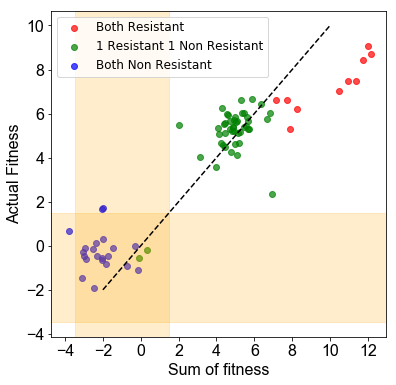

In [50]:
plt.figure(figsize=(6,6))

df_positives_100 = df_unique_double_hundred.loc[(df_unique_double_hundred.hundred_fitness1 > mu_100+2.96*sigma_100)\
                                           & (df_unique_double_hundred.hundred_fitness2 > mu_100+2.96*sigma_100)]

plt.scatter(df_positives_100.fitness_sum, df_positives_100.hundred_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 > mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.96*sigma_100))|
                                        ((df_unique_double_hundred.hundred_fitness1 < mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 > mu_100+2.96*sigma_100))]
plt.scatter(df_neutral_100.fitness_sum, df_neutral_100.hundred_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Non Resistant')

df_neutral_double_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 < mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.96*sigma_100))]

plt.scatter(df_neutral_double_100.fitness_sum, df_neutral_double_100.hundred_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Non Resistant')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_100+2.96*sigma_100, mu_100-2.96*sigma_100, alpha = 0.2, color = 'orange')
plt.axvspan(mu_100+2.96*sigma_100, mu_100-2.96*sigma_100, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 16)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 16)
plt.xticks(fontname = 'Arial', fontsize = 16)
plt.yticks(fontname = 'Arial', fontsize = 16)

plt.legend(fontsize = 12)
plt.savefig('Actual versus Predicted 100.svg',format = 'svg', dpi = 300)

In [51]:
df_unique_double_hundred = df_unique_double_hundred.assign(Sign_p_value = stats.norm.sf(abs((df_unique_double_hundred.fitness_sum - df_unique_double_hundred.hundred_fitness)/\
                            np.sqrt((np.square(df_unique_double_hundred.fitness_sum_error) + \
                                     np.square(df_unique_double_hundred.hundred_error))))))
mask = (df_unique_double_hundred.hundred_fitness>df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Positive'
mask = (df_unique_double_hundred.hundred_fitness<df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Negative'
mask = df_unique_double_hundred.Sign_p_value > 0.01
df_unique_double_hundred.loc[mask, 'Sign'] = 'Neutral'
df_unique_double_hundred.Sign.value_counts(normalize=True).values[1]*1000

155.84415584415584

In [52]:
df_unique_double_hundred.Sign.value_counts(normalize=True)*100

Neutral     81.818182
Positive    15.584416
Negative     2.597403
Name: Sign, dtype: float64

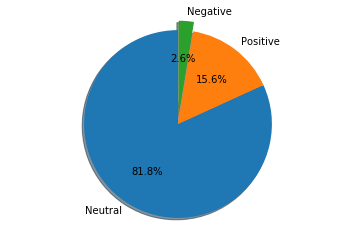

In [53]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Neutral', 'Positive','Negative'
sizes = [df_unique_double_hundred.Sign.value_counts(normalize=True).values[0]*100,\
        df_unique_double_hundred.Sign.value_counts(normalize=True).values[1]*100,\
        df_unique_double_hundred.Sign.value_counts(normalize=True).values[2]*100,]
explode = (0,0,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Mag_Epistasis_100.svg', format = 'svg', dpi = 300)

In [54]:
df_positives_100 = df_unique_double_hundred.loc[(df_unique_double_hundred.hundred_fitness1 > mu_100+2.96*sigma_100)\
                                           & (df_unique_double_hundred.hundred_fitness2 > mu_100+2.96*sigma_100)]


In [55]:
df_positives_100.Sign.value_counts(normalize=True)*100

Neutral     90.0
Negative    10.0
Name: Sign, dtype: float64

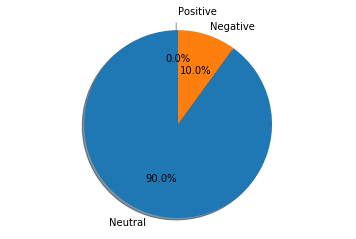

In [57]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Neutral', 'Negative', 'Positive'
sizes = [df_positives_100.Sign.value_counts(normalize=True).values[0]*100,\
        df_positives_100.Sign.value_counts(normalize=True).values[1]*100,\
        0]
explode = (0,0,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Mag_Epistasis_100.svg', format = 'svg', dpi = 300)

In [58]:
df_neutral_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 > mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.96*sigma_100))|
                                        ((df_unique_double_hundred.hundred_fitness1 < mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 > mu_100+2.96*sigma_100))]

In [59]:
df_neutral_100.Sign.value_counts()

Neutral     44
Negative     1
Positive     1
Name: Sign, dtype: int64

In [60]:
df_neutral_double_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 < mu_100+2.96*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.96*sigma_100))]

In [61]:
df_neutral_double_100.Sign.value_counts()

Positive    11
Neutral     10
Name: Sign, dtype: int64

In [62]:
df_reiprocal = df_neutral_double_100.loc[df_neutral_double_100.hundred_fitness >= mu_100+2.96*sigma_100]

In [63]:
df_reiprocal = df_reiprocal.loc[df_reiprocal.Sign == 'Positive']
df_reiprocal['base_fitness'] = [0,0,0,0]
df_reiprocal[['base_fitness','hundred_fitness1','hundred_fitness2','hundred_fitness']]


ValueError: Length of values does not match length of index

In [52]:
df_positives_100

,Mutations,hundred_fitness,hundred_error,Mutation1,Mutation2,Mutation1A,hundred_fitness1,hundred_error1,Mutation2A,hundred_fitness2,hundred_error2,fitness_sum,fitness_sum_error,Sign_p_value,Sign
Non_Syn_Mutations,,,,,,,,,,,,,,,
"D596N,H526L","D596N,H526L",6.637292,0.072296,D596N,H526L,D596N,2.121953,2.401564,H526L,5.614612,2.253969,7.736565,3.293612,0.369311,Neutral
"D596N,I572F","D596N,I572F",6.240273,1.477577,D596N,I572F,D596N,2.121953,2.401564,I572F,6.112289,0.652151,8.234242,2.488536,0.245422,Neutral
"H526L,I572F","H526L,I572F",8.428665,1.206363,H526L,I572F,H526L,5.614612,2.253969,I572F,6.112289,0.652151,11.726902,2.346418,0.105631,Neutral
"H526L,I572Y","H526L,I572Y",7.454741,2.879139,H526L,I572Y,H526L,5.614612,2.253969,I572Y,5.351492,2.595470,10.966105,3.437563,0.216788,Neutral
"H526L,P564L","H526L,P564L",7.035296,1.679920,H526L,P564L,H526L,5.614612,2.253969,P564L,4.877188,0.359641,10.491801,2.282480,0.111302,Neutral
"H526L,S531F","H526L,S531F",6.926778,1.476705,H526L,S531F,H526L,5.614612,2.253969,S531F,6.046381,1.073819,11.660993,2.496690,0.051330,Neutral
"H526L,T595S","H526L,T595S",6.610893,1.776932,H526L,T595S,H526L,5.614612,2.253969,T595S,1.510139,0.046828,7.124751,2.254455,0.428965,Neutral
"L538P,H526L","L538P,H526L",5.498741,1.915713,L538P,H526L,L538P,1.606429,1.670196,H526L,5.614612,2.253969,7.221042,2.805340,0.306077,Neutral
"R529H,H526L","R529H,H526L",5.285966,1.970902,R529H,H526L,R529H,2.290761,0.356715,H526L,5.614612,2.253969,7.905374,2.282021,0.192505,Neutral
